# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import string
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lex_div = unique_tokens / len(tokens)
    common_tokens = Counter(tokens).most_common(num_tokens)
    
    if verbose:
        print(f"Number of tokens: {len(tokens)}")
        print(f"Number of unique tokens: {unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lex_div}")
        print(f"{num_tokens} most common tokens: {common_tokens}")
    
    return len(tokens), unique_tokens, num_characters, lex_div, common_tokens


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [7]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/micha/applied text mining/mod 1/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [8]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [9]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [10]:
# Setting artists
artists = ['cher', 'robyn']

# Dict to hold lyric data
lyrics_data = {}

for artist in artists:
    # Path for artist's lyrics folder
    artist_folder = os.path.join(data_location, lyrics_folder, artist)

    # List of all the song files in the artist's lyrics folder
    song_files = os.listdir(artist_folder)

    # Dict to hold the artist's songs
    artist_songs = {}

    for song_file in song_files:
        # Path to the song file
        song_path = os.path.join(artist_folder, song_file)

        with open(song_path, 'r') as file:
            lyrics = file.read().strip()

        artist_songs[song_file[:-4]] = lyrics

    # Adding song to lyric dict
    lyrics_data[artist] = artist_songs

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [11]:
def lowercase(text):
    return text.lower()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize(text):
    return text.split()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word not in stop_words]

def contains_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # pictographs
                           u"\U0001F680-\U0001F6FF"  # map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

In [12]:
def lowercase(text):
    # Checks if text is string
    if isinstance(text, str): 
        return text.lower()
    else:
        return ""  

In [26]:
def apply_pipeline(df, col_name, pipeline):
    if col_name in df.columns:
        df["tokens"] = df[col_name].apply(lambda text: prepare(text, pipeline=pipeline) if isinstance(text, str) else [])
        df["num_tokens"] = df["tokens"].apply(len)
        df['has_emoji'] = df[col_name].apply(lambda text: contains_emoji(text) if isinstance(text, str) else False)
    else:
        print(f"No '{col_name}' column in dataframe")

# Apply pipelines
for artist in lyrics_data:
    for song in lyrics_data[artist]:
        lyrics_data[artist][song] = prepare(lyrics_data[artist][song], pipeline=lyrics_pipeline)

apply_pipeline(twitter_data, "description", twitter_pipeline)

In [14]:
def process_text(data, pipeline):
    return [pipeline(word) for word in data if isinstance(word, str)]

# Apply pipeline to each song lyric
for artist in lyrics_data:
    for song in lyrics_data[artist]:
        lyrics_data[artist][song] = process_text(lyrics_data[artist][song], my_pipeline)
        lyrics_data[artist][song] = len(lyrics_data[artist][song])

# Apply pipeline to the description
if "description" in twitter_data.columns:
    twitter_data["tokens"] = process_text(twitter_data["description"], my_pipeline)
    twitter_data["num_tokens"] = twitter_data["tokens"].apply(len)
else:
    print("No 'description' column in twitter_data")

In [27]:
if "has_emoji" in twitter_data.columns:
    sample_with_emoji = twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]
    print(sample_with_emoji)
else:
    print("No 'has_emoji' column in twitter_data")

        artist                                        description  \
3114201   cher                                  Oni #Soscuba 🇨🇺🇨🇺   
106552   robyn  We are a new British trio called Triple Tone, ...   
673647    cher  Follow my ig @anastacia_memes for Anastacia me...   
1783653   cher                                     ✖️Barber✖️ 💈⚔️   
170840    cher                                        she/her 🙃🙃🙃   
1492839   cher  I’m always sad. Gay disaster. He/him. Settler ...   
73097     cher  Freedom of Speech. Joie de vivre. Cerebro mata...   
2950673   cher  *♡*La vie est comme un roman. Il suffit d'une ...   
2980784   cher                                            Chile🇨🇱   
1243183   cher  Publishing. Heavily addicted to Yorkshire Gold...   

                                                    tokens  
3114201                              [oni, #soscuba, 🇨🇺🇨🇺]  
106552   [new, british, trio, called, triple, tone,, pe...  
673647   [follow, ig, @anastacia_memes, anastacia, memes👀

Let's take a quick look at some descriptions with emojis.

In [16]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
910783,cher,"Contadora Pública, por fin. Practicante de Pol...",Contadora Pública por fin Practicante de Pole ...
149417,robyn,I have a pig-rabbit! Your argument is invalid!...,I have a pigrabbit Your argument is invalid I ...
771302,cher,"God First, Family Second, Work third. ❤️❤️",God First Family Second Work third ❤️❤️
1274314,cher,May pag asa pa Pilipinas laban lang #LetLeniLe...,May pag asa pa Pilipinas laban lang LetLeniLea...
1380639,cher,🔞🇪🇨 law student,🔞🇪🇨 law student
576163,cher,Se a onda não tem futuro nem rema 🌊,Se a onda não tem futuro nem rema 🌊
640445,cher,✨Stargirl✨,✨Stargirl✨
2393945,cher,si el que se enamora pierde estoy dispuesto a ...,si el que se enamora pierde estoy dispuesto a ...
3121653,cher,♠️Promotional Model | Sport Events Hostess | R...,♠️Promotional Model Sport Events Hostess Rec...
1543676,cher,Author of Cocktail/lifestyle book release in 2...,Author of Cocktaillifestyle book release in 20...


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One thing I see that we can improve on for tokenization is the "-" part. In the list above, "pig-rabbit" is separate with a "-" but when tokenized, is combined. Instead, there should be some other way to separate the two words.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [17]:
sample_with_emoji["num_tokens"] = sample_with_emoji["tokens"].apply(len)

In [30]:
# Average number of tokens per song 
lyrics_avg_tokens = {artist: sum(num_tokens.values())/len(num_tokens) for artist, num_tokens in lyrics_num_tokens.items()}

# Num_tokens
sample_with_emoji["num_tokens"] = sample_with_emoji["tokens"].apply(len)

# Average number of tokens per description 
emoji_avg_tokens = sample_with_emoji["num_tokens"].mean()

for artist, avg in lyrics_avg_tokens.items():
    print(f"Average number of tokens per song for {artist}: {avg}")

print(f"\nAverage number of tokens per description in sample_with_emoji: {emoji_avg_tokens}")

Average number of tokens per song for cher: 113.65822784810126
Average number of tokens per song for robyn: 146.41346153846155

Average number of tokens per description in sample_with_emoji: 7.7


Q: what observations do you make about these data? 

A: One observation is that the avg number of tokens in songs is significantly higher that that of descriptions in sample_with_emojis. This is probably because songs usually have much more content than a Twitter description, which is usually short and brief. Another observation is that the avg tokens person for Robyn is higher than cher. This could be because Robyns songs on avg might be longer than Cher's, thus having more words/content in it. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [31]:
def unique_tokens(corpora, min_freq=5):
    # Unique token for each corpus
    unique_tokens_per_corpus = {}
    all_tokens = Counter(token for corpus in corpora.values() for token in corpus)
    
    for corpus_name, corpus in corpora.items():
        # Counter for tokens
        corpus_counts = Counter(corpus)
        # Lengtth of corpus
        corpus_length = len(corpus)

        other_tokens = all_tokens - corpus_counts
        other_corpora_length = sum(all_tokens.values()) - corpus_length
        
        # Check count of token/token in other corpora
        unique_tokens = {}
        for token, count in corpus_counts.items():
            if count > min_freq and token in other_tokens:
                concentration_ratio = (count / corpus_length) / (other_tokens[token] / other_corpora_length)
                unique_tokens[token] = concentration_ratio
        
        # Descending order
        unique_tokens = sorted(unique_tokens.items(), key=lambda x: x[1], reverse=True)[:10]
        unique_tokens_per_corpus[corpus_name] = unique_tokens

    return unique_tokens_per_corpus

In [20]:
# Both iterating over
lyrics_tokens = [token for song in lyrics_data for token in lyrics_data[song]]
twitter_tokens = [token for user in twitter_data for token in twitter_data[user]]

In [21]:
# Returns flat list
def flatten(nested_list):
    return [item for sublist in nested_list if hasattr(sublist, '__iter__') for item in sublist if isinstance(item, str)]

lyrics_tokens_flat = flatten(lyrics_tokens)
twitter_tokens_flat = flatten(twitter_tokens)

In [32]:
corpora_dict = {
    "lyrics": lyrics_tokens_flat,
    "twitter": twitter_tokens_flat,
}

unique_tokens_dict = unique_tokens(corpora_dict, min_freq=5)

for name, tokens in unique_tokens_dict.items():
    print(f"Unique tokens for {name}:\n", "\n".join([f"{t}: {r}" for t, r in tokens]), "\n")

Unique tokens for lyrics:
 _: 24.349641848081138
b: 2.3420822754246293
h: 2.2093435598131426
w: 2.0807479199100527
y: 2.0179490176779877
c: 1.7962030614150595
o: 1.5293227946485741
r: 1.5150079316655987
v: 1.4559063847641998
e: 1.3952468235635282 

Unique tokens for twitter:
 z: 21.58979011136369
7: 6.628020974592627
6: 4.165835866149907
x: 4.101556476465138
9: 3.769932006405101
0: 3.505332357632267
3: 2.7734002924237533
2: 1.6767240694574903
8: 1.6462672926307116
j: 1.4449856591315193 



Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: An observation that I can see is that for unique tokens for lyrics, all are letters of the alphabet, except for "_". Another observation is that the unique tokens for twitter is mostly numbers. An interesting item on the list is "_" and "z" which are the highest.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [33]:
def clean_text(text):
    # Keeping printable characters
    return ''.join(c for c in text if c in printable)

def is_valid_word(word):
    # Word is valid if contain at least one alphabet letter and is more than 1 character long
    return len(word) > 1 and any(char.isalpha() for char in word)

def deEmojify(text):
    # Remove emojis with a regex pattern
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # pictographs
        u"\U0001F680-\U0001F6FF"  # map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [36]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, background_color="black", colormap="Paired", 
                   max_font_size=150, max_words=max_words,
                   font_path='C:\\Users\\micha\\applied text mining\\mod 3\\calibri.ttf'
    )

    # Convert pandas Series to dictionary
    if isinstance(word_freq, pd.Series):
        word_freq = word_freq.fillna(0).to_dict()

    # Remove stopwords
    if stopwords:
        word_freq = {k: v for k, v in word_freq.items() if k not in stopwords}

    # Generate wordcloud
    wc.generate_from_frequencies(word_freq)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title) 
    plt.axis("off")

In [38]:
def clean_text(text):
    printable = set(chr(i) for i in range(32, 127))
    # Keep printable character
    return ''.join(c for c in text if c in printable)

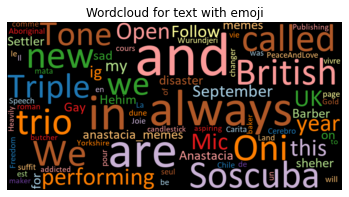

In [40]:
word_freq_dict = Counter(word for tokens in sample_with_emoji['description'].apply(word_tokenize) for word in tokens)

# Clean words, remove invalids, de-emote, and remove entries with empty keys
word_freq_dict = {
    deEmojify(re.sub(r'\W+', '', clean_text(word))): freq
    for word, freq in word_freq_dict.items() 
    if is_valid_word(word) and word.strip()
}

# Make Wordcloud
wordcloud(word_freq_dict, title="Wordcloud for text with emoji")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The biggest word in the wordcloud is "and", which makes sense since it is a really common word and most sentence usually has it. Other big words in the wordcloud also include "are", "in", and "We" which are relatively common words. "We" is also capitalized as well meaning that it is used in the beginning of sentences a lot. 